# WaveTENet: A Wavelet Transform Network for Predicting Transport Properties of Thermoelectric Materials #
### TELab, ITS, WHU ###

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 设置随机种子
torch.manual_seed(42)
np.random.seed(42)

# 设置超参数
target = 'zT'
leixing = 'mixed'
target_indices = {
    's': 1,
    'sigma': 2,
    'pf': 3,
    'tc': 4,
    'zT': 5
}
input_length = 474 if leixing=='orig' else 948  # 输入特征维度
input_length = 948  # 输入特征维度
blocks = 6  # DenseNet中的Dense Block数
dropout_prob = 0  # 每个Dense Block中的Dropout概率
learning_rate = 0.00001  # 学习率
weight_decay = 0.001  # L2正则化权重衰减
epochs = 3000  # 训练的总轮数
random_state = 2024
scale_number=1


# Model Definition #

In [5]:
class DenseNet(nn.Module):
    def __init__(self, input_length, blocks, dropout_prob=dropout_prob):
        super(DenseNet, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_length, input_length),
            nn.BatchNorm1d(input_length),
            nn.ReLU()
        )
        self.dense_blocks = nn.ModuleList()
        for _ in range(blocks):
            self.dense_blocks.append(self.building_block(input_length, dropout_prob))
        self.output_layer = nn.Sequential(
            nn.BatchNorm1d(input_length),
            nn.Linear(input_length, 1)
        )
        
    def building_block(self, input_length, dropout_prob):
        block = nn.Sequential(
            nn.BatchNorm1d(input_length),
            nn.Linear(input_length, input_length),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(input_length),
            nn.Linear(input_length, input_length),
            nn.ReLU(),
            nn.Dropout(dropout_prob),
            nn.BatchNorm1d(input_length),
            nn.Linear(input_length, input_length),
            nn.ReLU(),
            nn.Dropout(dropout_prob)
        )
        return block

    def forward(self, x):
        x = self.input_layer(x)
        for dense_block in self.dense_blocks:
            out = dense_block(x)
            x = out + x
        x = self.output_layer(x)
        return x


# Read dataset #

In [6]:
target_index = target_indices[target]

path = f"dataset/{leixing}-dope.csv"
data = pd.read_csv(path)
x = data.iloc[:, 6:].values
y = data.iloc[:, target_index].values.reshape(-1, 1) * scale_number
scaler_x = MinMaxScaler()
x = scaler_x.fit_transform(x)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=random_state)
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)
train_loader = data_utils.DataLoader(data_utils.TensorDataset(X_train, y_train), batch_size=X_train.shape[0], shuffle=False)


# Training #

In [7]:
model = DenseNet(input_length=input_length, blocks=blocks, dropout_prob=dropout_prob).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses = []
test_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    with torch.no_grad():
        test_outputs = model(X_test)
        test_loss = criterion(test_outputs, y_test)
        test_r2=r2_score(test_outputs.cpu(),y_test.cpu())
        train_r2=r2_score(model(X_train).cpu(),y_train.cpu())
        test_losses.append(test_loss.item())

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], train_r2: {train_r2}, test_r2: {test_r2}')

model.eval()
with torch.no_grad():
    yhat_train = model(X_train)
    yhat_test = model(X_test)
    test_mse = mean_squared_error(yhat_test.cpu(), y_test.cpu())
    r2 = r2_score(y_test.cpu(), yhat_test.cpu())
    print(f'Test MSE: {test_mse:.4f}')
    print(f'Test R²: {r2:.4f}')


Epoch [10/3000], train_r2: -55.60389472884059, test_r2: -57.64536452229377
Epoch [20/3000], train_r2: -17.641368278920353, test_r2: -18.921108627079576
Epoch [30/3000], train_r2: -3.916861101521471, test_r2: -3.6689396870010738
Epoch [40/3000], train_r2: -1.9813102975735246, test_r2: -1.8816583493569388
Epoch [50/3000], train_r2: -1.4610527527595378, test_r2: -1.457560365167578
Epoch [60/3000], train_r2: -0.713892059416054, test_r2: -0.5724686366688956
Epoch [70/3000], train_r2: -0.2927408571508663, test_r2: -0.2498883539316643
Epoch [80/3000], train_r2: -0.1677694273492627, test_r2: -0.17064329984120086
Epoch [90/3000], train_r2: -0.12834411022292458, test_r2: -0.14274853304965784
Epoch [100/3000], train_r2: -0.1109111050188325, test_r2: -0.1311298516037589
Epoch [110/3000], train_r2: -0.09807568679196077, test_r2: -0.11969102722034042
Epoch [120/3000], train_r2: -0.08653334437799454, test_r2: -0.10890302446982347
Epoch [130/3000], train_r2: -0.07454812350061868, test_r2: -0.097358801

# Visiualization #

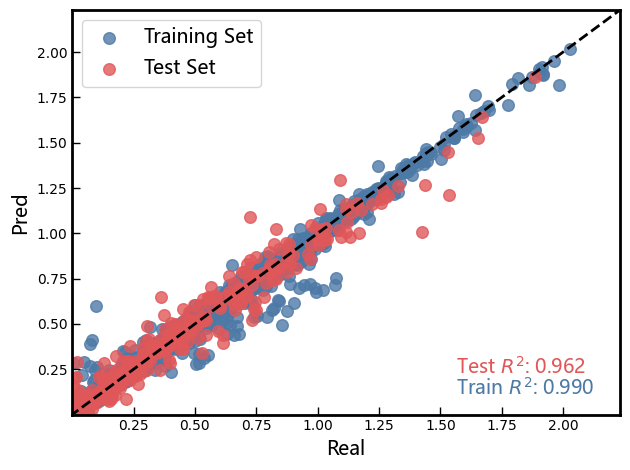

In [8]:
y_train_np = y_train.cpu().numpy()
yhat_train_np = yhat_train.cpu().numpy()
y_test_np = y_test.cpu().numpy()
yhat_test_np = yhat_test.cpu().numpy()

plt.scatter(y_train_np, yhat_train_np, alpha=0.8, label='Training Set', color='#4d79a6', s=70)
plt.scatter(y_test_np, yhat_test_np, alpha=0.8, label='Test Set', color='#e05759', s=70)
plt.plot([-10000, 10000], [-10000, 10000], 'k--', lw=2)

plt.xlabel('Real', fontdict={'family': 'Microsoft YaHei', 'size': 14})
plt.ylabel('Pred', fontdict={'family': 'Microsoft YaHei', 'size': 14})

downlim = min(min(y_train_np), min(y_test_np)) * 0.9
uplim = max(max(y_train_np), max(y_test_np)) * 1.1
plt.axis([downlim, uplim, downlim, uplim])

r2_train = r2_score(y_train_np, yhat_train_np)
r2_test = r2_score(y_test_np, yhat_test_np)
plt.text(0.7, 0.05, f'Train $R^2$: {r2_train:.3f}', fontdict={'family': 'Microsoft YaHei', 'size': 14}, transform=plt.gca().transAxes, color='#4d79a6')
plt.text(0.7, 0.1, f'Test $R^2$: {r2_test:.3f}', fontdict={'family': 'Microsoft YaHei', 'size': 14}, transform=plt.gca().transAxes, color='#e05759')

plt.tick_params(direction='in', length=6, width=1, which='both')
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)

plt.legend(prop={'family': 'Microsoft YaHei', 'size': 14})

plt.tight_layout()
plt.show()


In [9]:
plt.plot(train_losses, color='#4d79a6', linewidth=2, label='Train Loss')
plt.plot(test_losses, color='#e05759', linewidth=2, label='Test Loss')

plt.xlabel('Epochs', fontdict={'family': 'Microsoft YaHei', 'size': 14})
plt.ylabel('Loss', fontdict={'family': 'Microsoft YaHei', 'size': 14})
plt.title('Loss Curve', fontdict={'family': 'Microsoft YaHei', 'size': 16})

plt.tick_params(direction='in', length=6, width=1, which='both')
plt.gca().spines['bottom'].set_linewidth(2)
plt.gca().spines['left'].set_linewidth(2)
plt.gca().spines['right'].set_linewidth(2)
plt.gca().spines['top'].set_linewidth(2)

plt.legend(prop={'family': 'Microsoft YaHei', 'size': 12})
plt.tight_layout()
plt.show()


# Save the results #

In [10]:
import os
torch.save(model.state_dict(), f'{target}-{leixing}.pth')
os.makedirs('no-dropout', exist_ok=True)

# 导出训练集和测试集预测结果
formulas = data.iloc[:, 0].values

train_indices, test_indices = train_test_split(range(len(formulas)), test_size=0.1, random_state=2024)

# 导出训练集结果
train_results = pd.DataFrame({
    'formula': formulas[train_indices],
    'real_value': y_train_np.flatten()/scale_number,
    'predicted_value': yhat_train_np.flatten()/scale_number
})
train_results.to_csv(f'no-dropout/{target}_{leixing}_doped_train_results.csv', index=False)

# 导出测试集结果
test_results = pd.DataFrame({
    'formula': formulas[test_indices],
    'real_value': y_test_np.flatten()/scale_number,
    'predicted_value': yhat_test_np.flatten()/scale_number})
test_results.to_csv(f'no-dropout/{target}_{leixing}_doped_test_results.csv', index=False)


# 导出每个epoch的损失
loss_data = pd.DataFrame({
    'epoch': list(range(1, epochs + 1)),
    'train_loss': train_losses,
    'test_loss': test_losses
})
loss_data.to_csv(f'no-dropout/{target}_doped_{leixing}_epoch_losses.csv', index=False)

print('successfully exported')

successfully exported
